# Simulate JEMRIS Phantom with MRZero
(C) 2025 Forschungszentrum Jülich

Author: Jörg Felder

In [1]:
# check for dependencies
import importlib.util

packages = ['pytorch_finufft', 'git', 'pypulseq', 'MRzeroCore']
for package in packages:
    spec = importlib.util.find_spec(package)
    if (spec==None):
        print('Need to isntall package {}.'.format(package))
        if package=='pytorch_finufft':
            %pip install pytorch-finufft
        elif package=='git':
            %pip install gitpython
        elif package=='pypulseq':
            %pip install pypulseq
        elif package=='MRzeroCore':
            %pip install MRzeroCore

In [2]:
import os
import git

# clone qrage, if not present
if( not os.path.isdir('../qrage') ):
    print('qrage not installed, cloning ...')
    git.Git('../').clone('https://jugit.fz-juelich.de/inm-4/mr/qrage.git')

In [3]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, '../qrage')

In [4]:
import h5py
import torch

import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

In [5]:
# Set parameters
filepath = '.'

adiabatic_pulse_type: str='hypsec_n'        # valid pulse types ["hypsec", "hypsec_n", "wurst"]
adiabatic_pulse_overdrive=1.5

useJemrisSeq = False  # use JEMRIS sequence file
SimulateInversionEfficiency = False  # simulate inversion efficiency

phantom_slices = 1

system = pp.Opts(
    max_grad=28,
    grad_unit="mT/m",
    max_slew=150,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    # adc_dead_time=0,
    adc_dead_time=20e-6,
    grad_raster_time=50*1e-6
)

## 1. Load H5 Sample File and create MRZero sampe from it

In [6]:
# Read JEMRIS sample file
# filename = 'SheppLogan.h5'                                                # Standard SheppLogan Phanrom
filename = 'sample_DoubleSphere_R75_DX1p0_T1_1000_2000_T2_25_30.h5'         # Concenrtic spheres

fullfilename = os.path.join(filepath, filename)

# open h5 file for reading 
f = h5py.File(fullfilename, "r")

# Get the HDF5 group 'sample'
group = f['sample']

# read group data
data = group['data'][()]
offset = group['offset'][()]
resolution = group['resolution'][()]

# close file
f.close()

In [7]:
# converst JEMRIS sample data into torch tensors
T1 = np.divide( 1, data[:,:,1], out=np.zeros_like(data[:,:,1], dtype=float), where=data[:,:,1]!=0)
T2 = np.divide( 1, data[:,:,2], out=np.zeros_like(data[:,:,2], dtype=float), where=data[:,:,2]!=0)

PD = torch.tensor( np.transpose(data[:,:,0]) )
T1 = torch.tensor( np.transpose(T1 / 1e3) )      # conversion from ms to s required
T2 = torch.tensor( np.transpose(T2 / 1e3) )      # conversion from ms to s required
DB = torch.tensor( np.transpose(data[:,:,4]) )

In [8]:
# add axis and slices to the phantom
PD = PD[:,:,None]
T1 = T1[:,:,None]
T2 = T2[:,:,None]
DB = DB[:,:,None]

if phantom_slices > 1:
    PD = PD.repeat(1,1,phantom_slices)
    T1 = T1.repeat(1,1,phantom_slices)
    T2 = T2.repeat(1,1,phantom_slices)
    DB = DB.repeat(1,1,phantom_slices)

In [9]:
# create missing entries
T2dash = torch.ones_like(PD) * 0.0125     # 1/T2prime = 1/T2star - 1/T2, here T2=45ms, T2=33ms for GM from literature
D = torch.zeros_like(PD)
B1 = torch.zeros_like(PD)
B1[PD!=0] = 1.0
B1 = B1[None, :, :, :]                  # needs first axis to be number of coil elements
coil_sens = torch.ones_like(B1)


In [ ]:
# create the phantom
size = torch.tensor( (resolution[0,0]*PD.shape[0]/1000, resolution[1,0]*PD.shape[1]/1000, resolution[2,0]/1000*phantom_slices) )

# TEST
# size[2] *= 2
# T1[T1!=0] = 0.5
# T2[T2!=0] = 0.03

phantom = mr0.VoxelGridPhantom(PD=PD, T1=T1, T2=T2, T2dash=T2dash, D=D, B0=DB, B1=B1, coil_sens=coil_sens, size=size)

VoxelGridPhantom
size = tensor([0.1500, 0.1500, 0.0010])


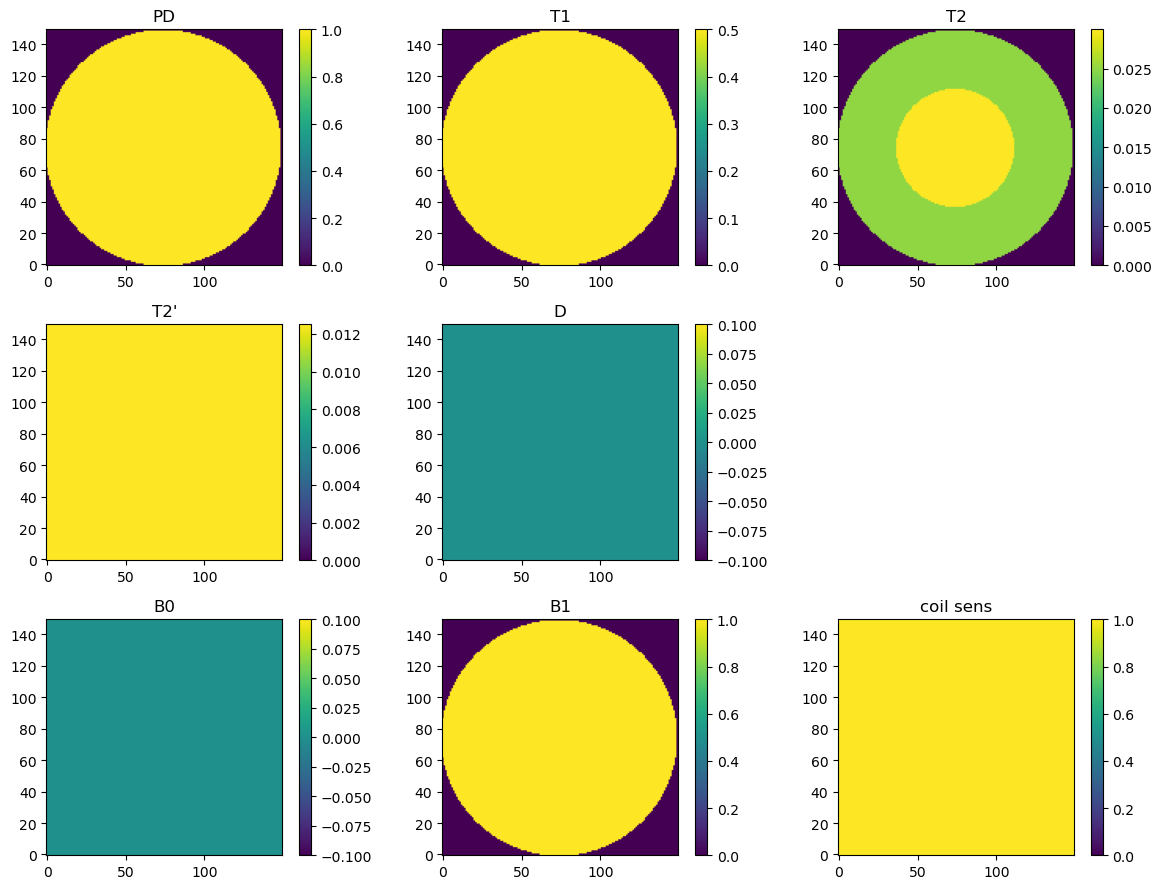

In [11]:
phantom.plot()

In [12]:
data = phantom.build()

## Alternate phantom

In [13]:
# # Uncomment the following lines to use the default brain phantom

# sz = [128, 128]
# obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat', size=torch.tensor([0.2, 0.2, 0.001]))
# obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# # Manipulate loaded data
# obj_p.D *= 0
# obj_p.B0 *= 0
# obj_p.plot()

# # Convert Phantom into simulation data
# obj_p = obj_p.build()

# data = obj_p

## 2. Create DI and standard GRE sequence with inversion pulse used in the QRAGE sequence

In [14]:
import math
from qrage.sequence.adiabatic import make_adiabatic_pulse

In [15]:
def write_sequence (plot: bool, write_seq: bool, seq_filename: str = 'gre_DI.seq', remove_prep_pulses: bool = False):
    
    # choose the scanner limits
    sys = system
    
    
    # Define FOV and resolution
    fov             = 200e-3
    slice_thickness = 5e-3
    n_slices        = 1
    Nread           = 64    # frequency encoding steps/samples
    Nphase          = 64    # phase encoding steps/samples

    # adiabatic pulse properties (default values from qrage sequence)
    adiabatic_pulse_duration: float = 10.24e-3
    adiabatic_pulse_dwell: float = 1e-5

    # Define sequence parameters
    TE              = 5e-3
    TR              = 500e-3
    TI              = 25e-3
    alpha           = 30

    dwell_time  = 10e-5                     # ADC dwell time 
    ro_duration = Nread * dwell_time        # ADC duration

    # Phase cycling
    rf_phase = 0
    rf_inc = 0
    rf_spoiling_inc = 117    

    # define the sequence
    seq = pp.Sequence()

    # Define excitation pulse
    rf, gz, _ = pp.make_sinc_pulse(
        flip_angle = alpha * np.pi / 180, 
        duration = 1e-3,
        slice_thickness = slice_thickness, 
        apodization = 0.5, 
        time_bw_product = 4,
        system = sys, 
        return_gz = True
    )

    # Define adiabatic rf pulse
    rf_adia = make_adiabatic_pulse(
        pulse_type=adiabatic_pulse_type,
        duration=adiabatic_pulse_duration,
        overdrive=adiabatic_pulse_overdrive,
        dwell=adiabatic_pulse_dwell,
        system=sys,
    )

    # Define other gradients and ADC events
    delta_k  =   1 / fov
    gx = pp.make_trapezoid(             # readout
        channel = 'x', 
        flat_area = Nread * delta_k, 
        flat_time = ro_duration, 
        system = sys
    )
    adc = pp.make_adc(
        num_samples = Nread, 
        duration = ro_duration, 
        phase_offset = 0 * np.pi/180,   # Will add offset in read loop
        delay = gx.rise_time, 
        system = sys
    )
    gx_pre = pp.make_trapezoid(         # prephaser readout
        channel = 'x', 
        area = -gx.area / 2, 
        duration = 1e-3, 
        system = sys
    )
    gz_reph = pp.make_trapezoid(        # rephase slice select
        channel = 'z', 
        area = -gz.area / 2, 
        duration = 1e-3, 
        system = sys
    )

    # phase encoding areas
    phase_areas = -(np.arange(Nphase)-Nphase//2)*delta_k

    # Create spoilers in read, phase and in slice
    gx_spoil = pp.make_trapezoid(
        channel = 'x', 
        area = 2 * Nread * delta_k, 
        system = sys
    )
    gy_spoil = pp.make_trapezoid(
        channel = 'y', 
        area = 2 * Nread * delta_k, 
        system = sys
    )
    gz_spoil = pp.make_trapezoid(
        channel = 'z', 
        area = 4 / slice_thickness, 
        system = sys
    )

    # Calculate timing
    if remove_prep_pulses:
        delay_TI = (
        math.ceil(
            (TI + rf_adia.shape_dur /2  - gz.rise_time - gz.flat_time / 2  )
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    else:
        delay_TI = (
            math.ceil(
                (TI - rf_adia.shape_dur * 3/2 - np.max([pp.calc_duration(gx_spoil), pp.calc_duration(gz_spoil)]) - gz.rise_time - gz.flat_time / 2  )
                / seq.grad_raster_time
            )
            * seq.grad_raster_time
        )
    delay_TE = (
        math.ceil(
            (TE - pp.calc_duration(gx_pre) - gz.fall_time - gz.flat_time / 2 - pp.calc_duration(gx) / 2)
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    delay_TR = (
        math.ceil(
            (TR - pp.calc_duration(gz) - pp.calc_duration(gx_pre) - pp.calc_duration(gx) - TE - TI)
            / seq.grad_raster_time
        )
        * seq.grad_raster_time
    )
    assert np.all(delay_TI >= 0)
    assert np.all(delay_TE >= 0)
    assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))

    # initial phases
    rf_phase = 0
    rf_inc = 0

    # set counter
    seq.add_block(pp.make_label(label='REV', type='SET', value=1))
    
    # ======
    # CONSTRUCT SEQUENCE
    # ======

    # Loop over slices
    for s in range(n_slices):
        rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
        rf_adia.freq_offset = rf.freq_offset

        # Loop over phase encodes and define sequence blocks
        for i in range(Nphase):
                
            rf.phase_offset = rf_phase / 180 * np.pi 
            rf_adia.phase_offset = rf.phase_offset
            adc.phase_offset = rf_phase / 180 * np.pi
            rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
            rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

            if remove_prep_pulses:
                seq.add_block(pp.make_delay(delay_TI))
            else:
                seq.add_block(rf_adia)
                seq.add_block(gx_spoil, gy_spoil, gz_spoil)
                seq.add_block(rf_adia)
                seq.add_block(pp.make_delay(delay_TI), gx_spoil, gy_spoil, gz_spoil)
            
            seq.add_block(rf, gz)
            gy_pre = pp.make_trapezoid(
                channel = 'y',
                area = phase_areas[i],
                duration = pp.calc_duration(gx_pre),
                system=sys,
            )
            seq.add_block(gx_pre, gy_pre, gz_reph)
            seq.add_block(pp.make_delay(delay_TE))
            seq.add_block(gx, adc)
            gy_pre.amplitude = -gy_pre.amplitude
            spoil_block_contents = [pp.make_delay(delay_TR), gx_spoil, gy_pre, gz_spoil]
            if i != Nphase - 1:
                spoil_block_contents.append(pp.make_label(type='INC', label='LIN', value=1))
            else:
                spoil_block_contents.extend(
                    [
                        pp.make_label(type='SET', label='LIN', value=0),
                        pp.make_label(type='INC', label='SLC', value=1),
                    ]
                )
            seq.add_block(*spoil_block_contents)

    # export sequence definitions
    seq.set_definition('FOV', [fov, fov, slice_thickness])
    #seq.set_definition('TE', TE)
    #seq.set_definition('TR', TR)
    #seq.set_definition('TI', TI)
    seq.set_definition('Nread', Nread)
    seq.set_definition('Nphase', Nphase)

    # check timiing
    ok, error_report = seq.check_timing()

    if ok:
        print('Timing check passed successfully')
    else:
        print('Timing check failed. Error listing follows:')
        [print(e) for e in error_report]
    
    # ======
    # VISUALIZATION
    # ======
    if plot:
        seq.plot(time_range=np.array([0, 1])*TR, time_disp='ms', grad_disp='mT/m')

    # =====
    # Print information
    # =====
    # print('The amplitude of the excitation pulse is {} Hz'.format(np.max(rf.signal)))

    rep = seq.test_report()
    print(rep)

    # pns_ok, pns_norm, pns_component, t_pns = seq.calculate_pns(
    #     hardware='/home/jovyan/scripts/pulseq_lissajous/MP_GPA_K2309_2250V_951A_AS82_GSWD_SAFETY.asc',
    # )

    spects, spects_sos, freq, _ = seq.calculate_gradient_spectrum( plot=True, 
            acoustic_resonances=[{'frequency': 1100, 'bandwidth': 300}, {'frequency': 550, 'bandwidth': 100}])
    plt.show()
    res_freqs = freq[np.argmax(spects, axis=1)]
    print('Resonate frequencies of gradients (x, y, z) are: ', res_freqs)

    # show SAR Plot
    plt.plot()
    pp.SAR.SAR_calc.calc_SAR(seq)
    

    # =========
    # WRITE .SEQ
    # =========
    if write_seq:
        seq.write(seq_filename)

In [16]:
if(SimulateInversionEfficiency):
    seq_filename = os.path.join(filepath, 'gre_DI.seq')
    write_sequence(plot=False, write_seq=True, seq_filename=seq_filename, remove_prep_pulses=False)

In [17]:
if(SimulateInversionEfficiency):
    seq_filename = os.path.join(filepath, 'gre_noDI.seq')
    write_sequence(plot=False, write_seq=True, seq_filename=seq_filename, remove_prep_pulses=True)

## 3. Simmulate standard GRE sequence for Testing

In [18]:
if(SimulateInversionEfficiency):
    # Select sequence file
    seq_filename = os.path.join(filepath, 'gre_noDI.seq')

    seq0 = mr0.Sequence.import_file(seq_filename)

    # Very precise simulation
    # graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
    # signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

    # Average precision
    graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
    signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

### Reconstruct image

In [19]:
if(SimulateInversionEfficiency):
    seq = pp.Sequence()
    seq.read(seq_filename)

    permvec = seq.evaluate_labels(evolution='adc')['LIN']
    Nphase = len(permvec)
    Nread = int(seq.adc_library.data[1][0])

    kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
    ipermvec = np.argsort(permvec)
    kspace=kspace[:,ipermvec]

In [20]:
if(SimulateInversionEfficiency):
    # fftshift FFT fftshift
    spectrum = torch.fft.fftshift(kspace)
    space = torch.fft.fft2(spectrum)
    space_NoInv = torch.fft.ifftshift(space)

In [21]:
if(SimulateInversionEfficiency):
    plt.title('GRE')
    mr0.util.imshow(np.abs(space_NoInv.numpy()))
    plt.colorbar()

## 4. Simulte GRE Sequence with double inversion

In [22]:
if(SimulateInversionEfficiency):
    seq_filename = os.path.join(filepath, 'gre_DI.seq')

    seq0 = mr0.Sequence.import_file(seq_filename)

    # Very precise simulation
    # graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
    # signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

    # Average precision
    graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
    signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

### Reconstruct image

In [23]:
if(SimulateInversionEfficiency):
    seq = pp.Sequence()
    seq.read(seq_filename)

    permvec = seq.evaluate_labels(evolution='adc')['LIN']
    Nphase = len(permvec)
    Nread = int(seq.adc_library.data[1][0])

    kspace = torch.reshape((signal), (Nphase, Nread)).clone().t()
    ipermvec = np.argsort(permvec)
    kspace=kspace[:,ipermvec]

In [24]:
if(SimulateInversionEfficiency):
    # fftshift FFT fftshift
    spectrum = torch.fft.fftshift(kspace)
    space = torch.fft.fft2(spectrum)
    space_DI = torch.fft.ifftshift(space)

In [25]:
if(SimulateInversionEfficiency):
    plt.title('Double Inversion')
    mr0.util.imshow(np.abs(space_DI.numpy()))
    plt.colorbar()

## 5. Compute inversion efficiency map

In [26]:
if(SimulateInversionEfficiency):
    Mask = np.abs(space_NoInv.numpy()) > 0.15 * np.max(np.abs(space_NoInv.numpy()))
    mr0.util.imshow(Mask)
    plt.colorbar()

In [27]:
if(SimulateInversionEfficiency):
    MzStart = np.mean(np.abs(space_NoInv.numpy()[Mask]))
    MzEnd = np.mean(np.abs(space_DI.numpy()[Mask]))
    FAEnd = 1/2*np.rad2deg(np.arccos(MzEnd/MzStart))
    IE = np.cos(np.deg2rad(FAEnd))*100

    print('Magnetization (M0z) is {}.'.format(MzStart))
    print('Magnetization Mz after two inversion pulses is {}.'.format(MzEnd))
    print('Flip angle after two inversions is {} degrees.'.format(FAEnd))
    print('Inversion efficiency  is {}%.'.format(IE))

In [28]:
if(SimulateInversionEfficiency):
    # Plot data for sake of sanity checking
    #
    # See https://matplotlib.org/stable/gallery/color/colorbar_basics.html for colorbar options
    #
    vmin = 0
    vmax = torch.max(torch.abs(space_NoInv))

    SignalRatio = np.zeros_like(space_DI.numpy(), dtype=float)
    np.divide( np.abs(space_DI.numpy()), np.abs(space_NoInv.numpy()), out=SignalRatio, where=Mask==1, dtype=float)
    FAEndPlot = 1/2*np.rad2deg(np.arccos(SignalRatio))
    IEPlot = np.cos(np.deg2rad(FAEndPlot))*100

    f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10,3.3))
    pos = ax1.imshow(np.abs(space_DI.numpy())*Mask,vmin=vmin, vmax=vmax)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.set_title('Double Inversion')
    ax1.set(xticklabels=[])
    ax1.set(yticklabels=[])
    ax1.tick_params(left=False, bottom=False)
    f.colorbar(pos, ax=ax1)
    pos = ax2.imshow(np.abs(space_NoInv.numpy())*Mask,vmin=vmin, vmax=vmax)
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.set_title('No Inversion')
    ax2.set(xticklabels=[])
    ax2.set(yticklabels=[])
    ax2.tick_params(left=False, bottom=False)
    f.colorbar(pos, ax=ax2)
    pos = ax3.imshow(IEPlot * Mask, vmin=90, vmax=100, cmap='jet')
    ax3.set_ylabel('')
    ax3.set_xlabel('')
    ax3.set_title('Inversion Efficiency')
    ax3.set(xticklabels=[])
    ax3.set(yticklabels=[])
    ax3.tick_params(left=False, bottom=False)
    f.colorbar(pos, ax=ax3)

## 6. Create QRAGE sequence and simulate

In [29]:
import sys
import platform
from types import SimpleNamespace

In [30]:
from qrage.sequence.qrage import QRAGE

### Create Sequence

In [31]:
seq_write = True
seq_plot = True
seq_calculate_gradient_spectrum = True
seq_check_timing = False
seq_test_report = False
seq_filename = os.path.join (filepath, 'qrage.seq')

In [32]:
seq = pp.Sequence()

num_spokes = 64
num_sets = 9
num_echoes = 3
num_partitions_per_block = 8
num_autocalibration_lines = 32
acceleration_factor = 1
fov = np.array([200, 200, 16]) * 1e-3
matrix_size = np.array([128, 128, 8])
readout_bandwidth = 390.625

axes = SimpleNamespace()

xyz = ["x", "y", "z"]

axes.d1 = "x"  # Readout dimension
axes.d2 = "y"  # Inner phase-encoding loop
axes.d3 = "z"  # Outer phase-enconding loop

axes.n1 = xyz.index(axes.d1)
axes.n2 = xyz.index(axes.d2)
axes.n3 = xyz.index(axes.d3)

In [33]:
seq.set_definition("FOV", fov.tolist())
seq.set_definition("RES", matrix_size.tolist())
seq.set_definition("Name", "QRAGE")

In [34]:
qrage = QRAGE(
    system,
    fov,
    matrix_size,
    axes,
    readout_bandwidth,
    num_spokes,
    num_sets,
    num_echoes,
    num_partitions_per_block,
    num_autocalibration_lines,
    acceleration_factor,
    adiabatic_pulse_type=adiabatic_pulse_type,
    adiabatic_pulse_overdrive=adiabatic_pulse_overdrive,
    debug=False
)

/workspaces/juart-dev/notebooks/../qrage/qrage/sequence/inversion.py:46: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  self.rf180 = make_adiabatic_pulse(
/workspaces/juart-dev/notebooks/../qrage/qrage/sequence/readout.py:94: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  pp.make_sinc_pulse(
/workspaces/juart-dev/notebooks/../qrage/qrage/sequence/readout.py:129: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  self.adc = pp.make_adc(


In [35]:
qrage.run(seq)

In [36]:
qrage.get_timing(seq)
print(
    "TR %s ms" % np.round(qrage.TR, decimals=1),
    "dTI %s ms" % np.round(qrage.dTI, decimals=1),
    "TI0 %s ms" % np.round(qrage.TI0, decimals=1),
    "dTE %s ms" % np.round(qrage.dTE, decimals=1),
    "TE0 %s ms" % np.round(qrage.TE0, decimals=1),
)

TR 951.4 ms dTI 104.0 ms TI0 56.8 ms dTE 8.0 ms TE0 4.5 ms


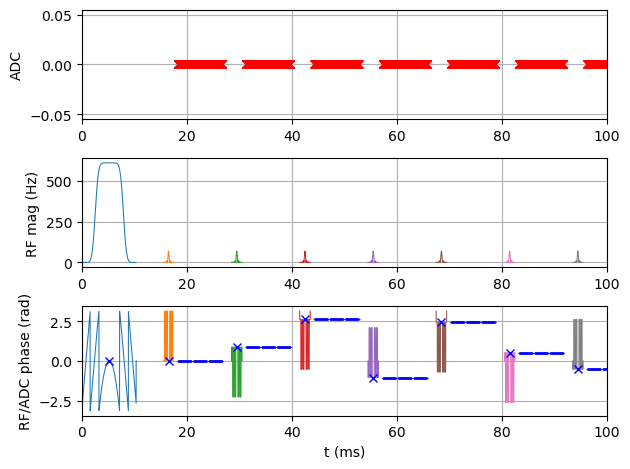

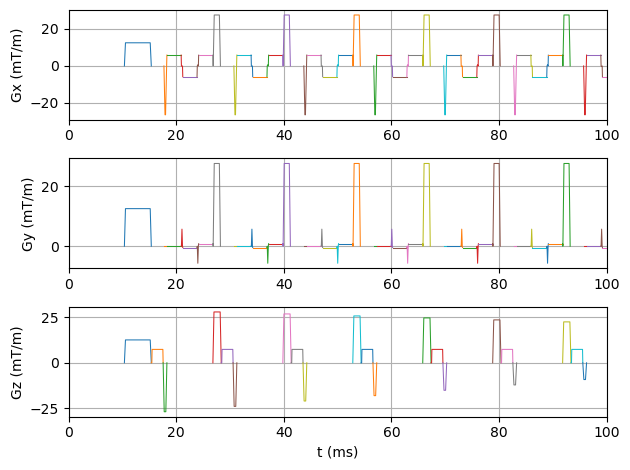

In [37]:
if seq_plot:
    seq.plot(time_range=[0, 0.1], grad_disp="mT/m", time_disp="ms", show_blocks=False)

Resonance frequencies of gradients (x, y, z) are:  [153.33333333 153.33333333  73.33333333]


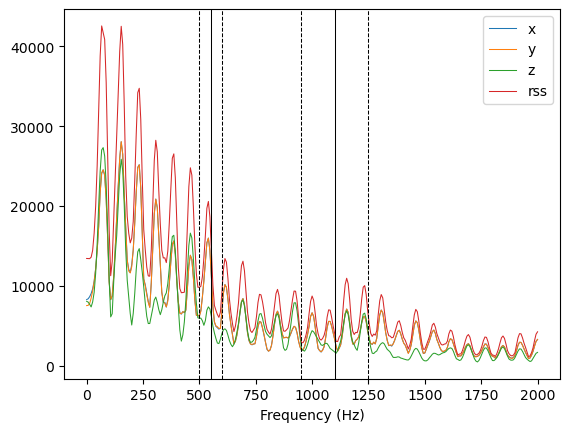

In [38]:
if seq_calculate_gradient_spectrum:
    spects, spects_sos, freq, _ = seq.calculate_gradient_spectrum( 
        acoustic_resonances=[{'frequency': 1100, 'bandwidth': 300}, {'frequency': 550, 'bandwidth': 100}])
    res_freqs = freq[np.argmax(spects, axis=1)]
    print("Resonance frequencies of gradients (x, y, z) are: ", res_freqs)

In [39]:
if seq_check_timing:
    ok, error_report = seq.check_timing()
    if ok:
        print("Timing check passed")
    else:
        print("Timing check failed")
        [print(e) for e in error_report]

In [40]:
if seq_test_report:
    rep = seq.test_report()
    print(rep)

In [41]:
if seq_write:
    seq.write(seq_filename)

In [42]:
if useJemrisSeq:
    print('Using JEMRIS sequence file.')

    # converted from JEMRIS using the command:
    # `jemris -x -d -id=1 -f myseq_LowRes_PartLoop_New_Mod_AdiaInvPulse myseq_LowRes_PartLoop_New_Mod_AdiaInvPulse.xml`
    seq_filename = os.path.join(filepath, 'myseq_LowRes_PartLoop_New_Mod_AdiaInvPulse.seq')

    num_spokes = 16
    num_sets = 19
    num_echoes = 9
    num_partitions_per_block = 1
    num_autocalibration_lines = 1
    acceleration_factor = 1
    fov = np.array([220, 220, 1]) * 1e-3
    matrix_size = np.array([64, 64, 1])

    qrage.dTI = 500
    qrage.TI0 = 260
    qrage.dTE = 2.8
    qrage.TE0 = 3.1
    qrage.TR = 9512.4

In [43]:
# Store sequence information for later processing in h5 file
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'w') as f:
    dset = f.create_dataset('num_spokes', data=num_spokes)
    dset = f.create_dataset('num_sets', data=num_sets)
    dset = f.create_dataset('num_echoes', data=num_echoes)
    dset = f.create_dataset('num_partitions_per_block', data=num_partitions_per_block)
    dset = f.create_dataset('num_autocalibration_lines', data=num_autocalibration_lines)
    dset = f.create_dataset('acceleration_factor', data=acceleration_factor)
    dset = f.create_dataset('matrix_size', data=matrix_size)
    dset = f.create_dataset('readout_bandwidth', data=readout_bandwidth)
    
    dset = f.create_dataset('dTI', data=qrage.dTI)
    dset = f.create_dataset('TI0', data=qrage.TI0)
    dset = f.create_dataset('dTE', data=qrage.dTE)
    dset = f.create_dataset('TE0', data=qrage.TE0)
    dset = f.create_dataset('TR', data=qrage.TR)

    dset = f.create_dataset('FoV', data=fov)


### Simulate

In [44]:
seq0 = mr0.Sequence.import_file(seq_filename)
print(seq_filename)

# Test is gradient scaling is correct
# for rep in seq0:
#     rep.gradm[:, 0] /= 0.2
#     rep.gradm[:, 1] /= 0.2
#     rep.gradm[:, 2] /= 0.2

# seq0.plot_kspace_trajectory()

./qrage.seq


In [45]:
# Very precise simulation
# graph = mr0.compute_graph(seq0, data, 10000, 1e-7)
# signal = mr0.execute_graph(graph, seq0, data, 1e-7, 1e-7)

# Average precision
# graph = mr0.compute_graph(seq0, data, 10000, 1e-4)
# signal = mr0.execute_graph(graph, seq0, data, 1e-3, 1e-4)

# low precision simulation
graph = mr0.compute_graph(seq0, data, 200, 1e-4)
if torch.cuda.is_available(): 
    print('>>>> Using CUDA for simulation <<<<.')
    signal = mr0.execute_graph(graph, seq0.cuda(), data.cuda(), 0.01, 0.01).cpu()
else:
    signal = mr0.execute_graph(graph, seq0, data, 0.01, 0.01)

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.046559498 s
Compute Graph
Computing Graph: 2.943089 s
Analyze Graph
Analyzing Graph: 0.084081195 s
Converting Rust -> Python: 1.0924172 s
<<<< Rust <<<<
Calculating repetition 4672 / 4672 - done


In [46]:
# Read sequence with pypulseq to get information on acquisition scheme
seq = pp.Sequence()
seq.read(seq_filename)

### Convert into ISMRMRD format (without full header)

In [47]:
# Tool from Felix Landmeyer to create ISMRMRD dataset from MRZERO simulation
import seqtraj_to_mrd

In [53]:
# Set required definitions
NCol = matrix_size[1]
seq.set_definition('MaxAdcSegmentLength',NCol)

# TEST
# seq.set_definition('MaxAdcSegmentLength',NCol/2)

In [54]:
# save file
seqtraj_to_mrd.mr0_to_mrd(seq, signal, os.path.join('..','LocalData', 'Simulations', 'qrage.h5'))

### Create MRD Dataset ###
